# fix-restarts

Fix restart files that have had the landmask enlarged. 
**Does not fix points where land has been changed to ocean.**

Use this in conjunction with bathymetry-closeup-baffin.ipynb

See https://github.com/OceansAus/access-om2/issues/99#issuecomment-396773493 and http://cosima.org.au/index.php/2018/06/12/technical-working-group-meeting-june-2018/


In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
import netCDF4 as nc
import IPython.display
import shutil

In [3]:
# see https://github.com/OceansAus/access-om2/issues/99
badbathyfile   = '/g/data3/hh5/tmp/cosima/bathymetry/topog_12_10_17_yenesei.nc'
# fixedbathyfile = '/g/data3/hh5/tmp/cosima/bathymetry/topog_12_06_2018.baffin.nc'
fixedbathyfile = '/g/data3/hh5/tmp/cosima/bathymetry/topog_13_06_2018.baffin.nc'


baddepth = nc.Dataset(badbathyfile).variables['depth'][:,:]
depth = nc.Dataset(fixedbathyfile).variables['depth'][:,:]


In [4]:
# from ocean_model_nml in ocean/input.nml
io_layout = (5, 5)

gridshape = np.shape(depth)  # NB: (y, x) order
tilex = int(np.round(gridshape[1]/io_layout[0]))  # tile x size
tiley = int(np.round(gridshape[0]/io_layout[1]))  # tile y size

In [5]:
maskdiff = np.logical_and(np.ma.getmask(depth), np.logical_not(np.ma.getmask(baddepth)))  # where land mask has increased
# maskdiff = np.ma.getmask(depth).astype(int)-np.ma.getmask(baddepth).astype(int)
# maskdiff[maskdiff<0] = 0  # don't consider reductions in land mask
jj,ii = np.nonzero(maskdiff)  # arrays of j, i coords where land mask has increased

xbox = (ii/tilex).astype(int)  # tile columns with land mask increases
ybox = (jj/tiley).astype(int)  # tile rows with land mask increases
tilenums = set(xbox+io_layout[0]*ybox)  # tiles with landmask increases (counting from 0)
tilenums

{17, 22, 24}

Use the tile numbers above to get the relevant restart files, e.g.
```
cd github/aekiss/notebooks
scp -rp aek156@r-dm.nci.org.au:/short/v45/aek156/access-om2/control/01deg_jra55_ryf/archive/restart387/ocean/ocean_barotropic.res.nc.0017 .
scp -rp aek156@r-dm.nci.org.au:/short/v45/aek156/access-om2/control/01deg_jra55_ryf/archive/restart387/ocean/ocean_barotropic.res.nc.0022 .
scp -rp aek156@r-dm.nci.org.au:/short/v45/aek156/access-om2/control/01deg_jra55_ryf/archive/restart387/ocean/ocean_barotropic.res.nc.0024 .
```

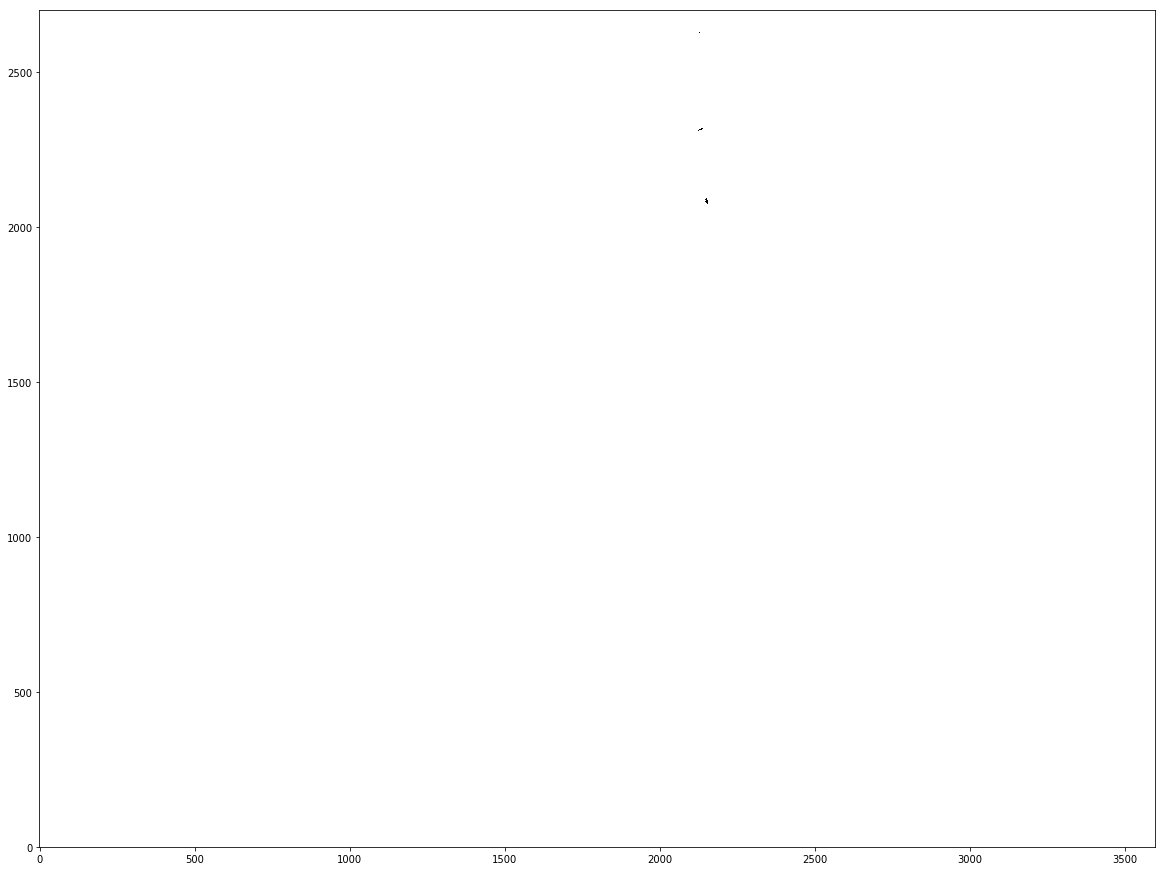

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(maskdiff, origin='lower', cmap=cm.binary)

tile 17
Fixing ocean_barotropic.res.nc.0017 eta_t; fixed version is ocean_barotropic.res.nc.0017-fixed
Fixing ocean_barotropic.res.nc.0017 eta_t_bar; fixed version is ocean_barotropic.res.nc.0017-fixed
tile 22
Fixing ocean_barotropic.res.nc.0022 eta_t; fixed version is ocean_barotropic.res.nc.0022-fixed
Fixing ocean_barotropic.res.nc.0022 eta_t_bar; fixed version is ocean_barotropic.res.nc.0022-fixed
tile 24
Fixing ocean_barotropic.res.nc.0024 eta_t; fixed version is ocean_barotropic.res.nc.0024-fixed
Fixing ocean_barotropic.res.nc.0024 eta_t_bar; fixed version is ocean_barotropic.res.nc.0024-fixed


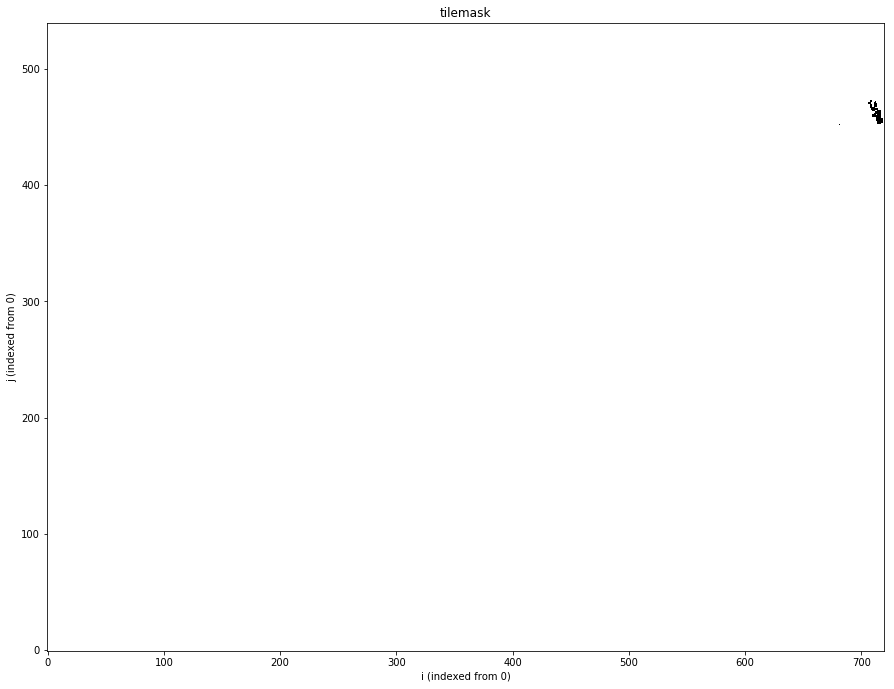

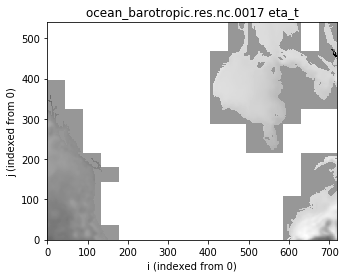

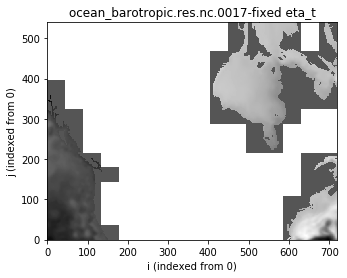

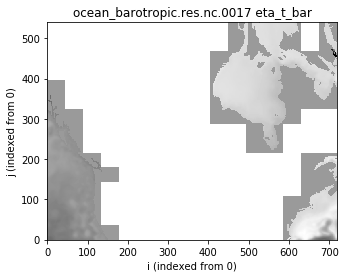

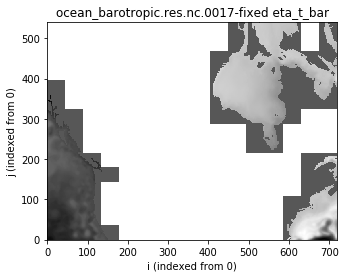

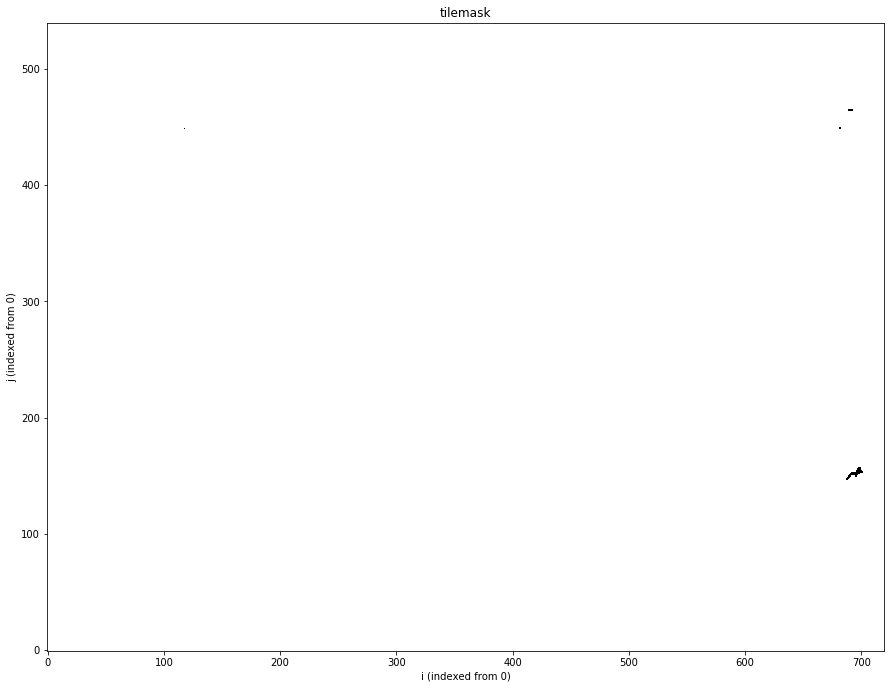

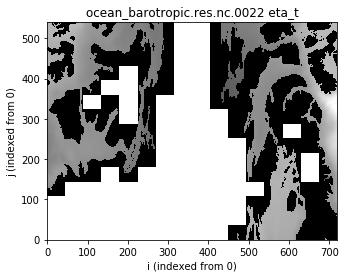

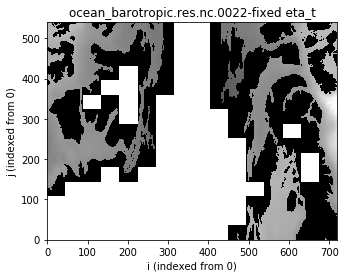

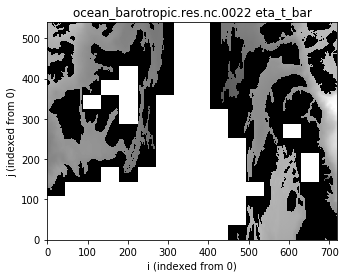

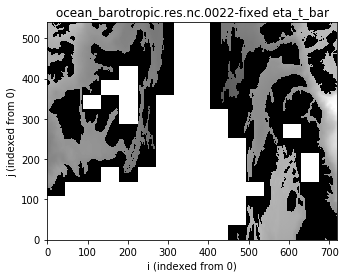

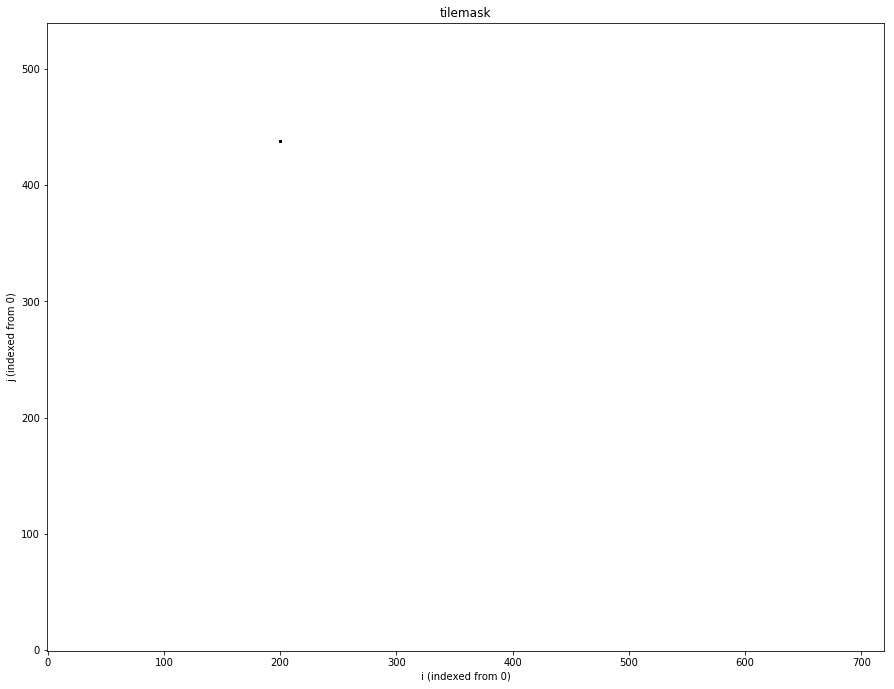

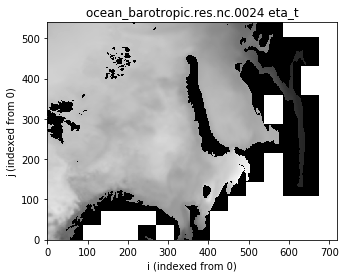

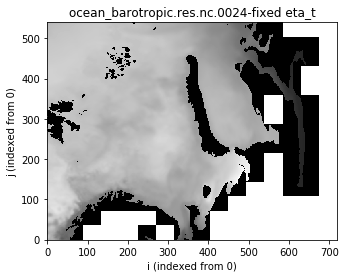

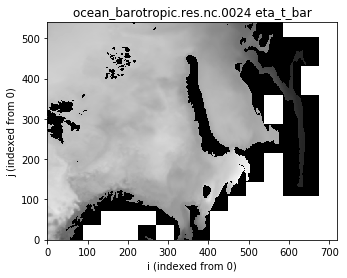

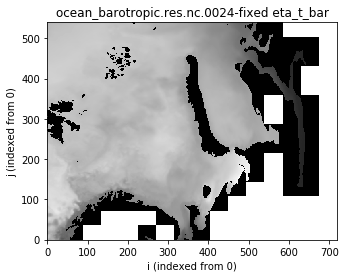

In [7]:
restartbase = 'ocean_barotropic.res.nc.'
varnames = ['eta_t', 'eta_t_bar']
for jtile in range(io_layout[1]):
    for itile in range(io_layout[0]):
        tilenum = itile+io_layout[0]*jtile
#         print(itile, jtile, tilenum)
        if tilenum in tilenums:
            print('tile '+str(tilenum))

            tilemask = maskdiff[jtile*tiley:(jtile+1)*tiley,itile*tilex:(itile+1)*tilex]
            plt.figure(figsize=(15,15))
            plt.imshow(tilemask, origin='lower', cmap=cm.binary)
            plt.title('tilemask')
            plt.xlabel('i (indexed from 0)')
            plt.ylabel('j (indexed from 0)');

            restartin = restartbase+str(tilenum).zfill(4)
            restartout = restartin+'-fixed'
            shutil.copy2(restartin, restartout)  # overwrites previous restartout (if any)
            
            for v in varnames:
                print('Fixing '+restartin+' '+v+'; fixed version is '+restartout)

                dset = nc.Dataset(restartout,'r+')
                plt.figure() #(figsize=(10,10))
                plt.imshow(dset[v][0,:,:], origin='lower', cmap=cm.binary)
                plt.title(restartin+' '+v)
                plt.xlabel('i (indexed from 0)')
                plt.ylabel('j (indexed from 0)');

                # set variable to zero at new land points 
                f = dset[v][0,:,:]
                f[tilemask] = 0.0
                dset[v][0,:,:] = f

                dset.close()  # write modified variable to restartout
                
                # now check restartout looks like it should
                dset = nc.Dataset(restartout,'r')
                plt.figure() #(figsize=(10,10))
                plt.imshow(dset[v][0,:,:], origin='lower', cmap=cm.binary)
                plt.title(restartout+' '+v)
                plt.xlabel('i (indexed from 0)')
                plt.ylabel('j (indexed from 0)');
                dset.close()
